In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ordustephen","key":"3b804872cd25495419d918e156a842b4"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d suchintikasarkar/sentiment-analysis-for-mental-health
!unzip sentiment-analysis-for-mental-health.zip

Dataset URL: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health
License(s): DbCL-1.0
  0% 0.00/11.1M [00:00<?, ?B/s]
100% 11.1M/11.1M [00:00<00:00, 405MB/s]
Archive:  sentiment-analysis-for-mental-health.zip
  inflating: Combined Data.csv       


In [5]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization (for EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Label Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
#  Transformers & Tokenization
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

# Torch (backend for Transformers)
import torch

#  Utility
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


In [7]:
df = pd.read_csv("Combined Data.csv")
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [8]:
df.shape

(53043, 3)

In [9]:
missing = df.isnull().sum()
missing

,0
Unnamed: 0,0
statement,362
status,0


In [10]:
df.columns.tolist()

['Unnamed: 0', 'statement', 'status']

In [11]:
# Drop rows with missing 'statement' values and reset the index
df = df.dropna(subset=['statement']).reset_index(drop=True)
# Drop the 'Unnamed: 0' column as it is not needed
df = df.drop(columns=['Unnamed: 0'])

In [12]:
df.columns = ['text', 'label']

In [13]:
df.head()

,text,label
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


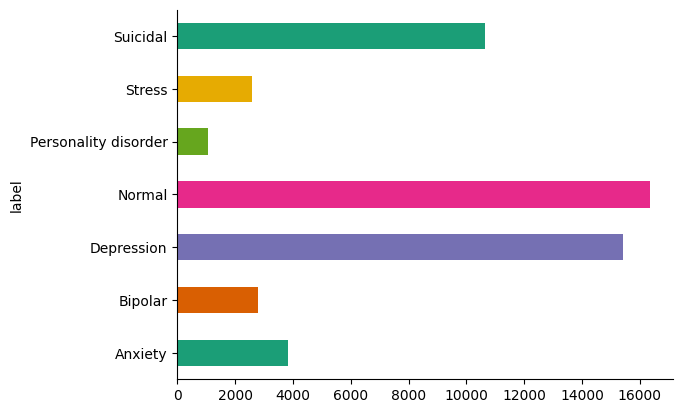

In [14]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [15]:
df["label"].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [16]:
from sklearn.preprocessing import LabelEncoder

# Lowercase and strip whitespace from the 'label' column
df['label'] = df['label'].str.strip().str.lower()

# Initialize and fit the LabelEncoder to the unique labels
le = LabelEncoder()
df['label_id'] = le.fit_transform(df['label'])

# Create dictionaries to map between original labels and their encoded IDs
label2id = dict(zip(le.classes_, le.transform(le.classes_)))
id2label = {v: k for k, v in label2id.items()}

# Print the mapping from labels to their IDs
print("Label mapping:", label2id)

Label mapping: {'anxiety': np.int64(0), 'bipolar': np.int64(1), 'depression': np.int64(2), 'normal': np.int64(3), 'personality disorder': np.int64(4), 'stress': np.int64(5), 'suicidal': np.int64(6)}


In [17]:
df.head()

,text,label,label_id
0,oh my gosh,anxiety,0
1,"trouble sleeping, confused mind, restless hear...",anxiety,0
2,"All wrong, back off dear, forward doubt. Stay ...",anxiety,0
3,I've shifted my focus to something else but I'...,anxiety,0
4,"I'm restless and restless, it's been a month n...",anxiety,0


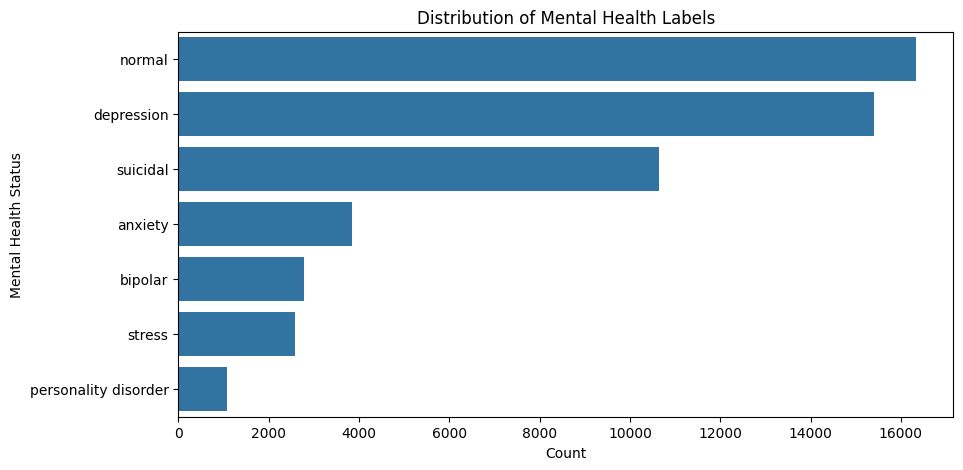

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(y=df['label'], order=df['label'].value_counts().index)
plt.title("Distribution of Mental Health Labels")
plt.xlabel("Count")
plt.ylabel("Mental Health Status")
plt.show()


In [19]:
label_counts = df['label'].value_counts()
print(label_counts)

label
normal                  16343
depression              15404
suicidal                10652
anxiety                  3841
bipolar                  2777
stress                   2587
personality disorder     1077
Name: count, dtype: int64


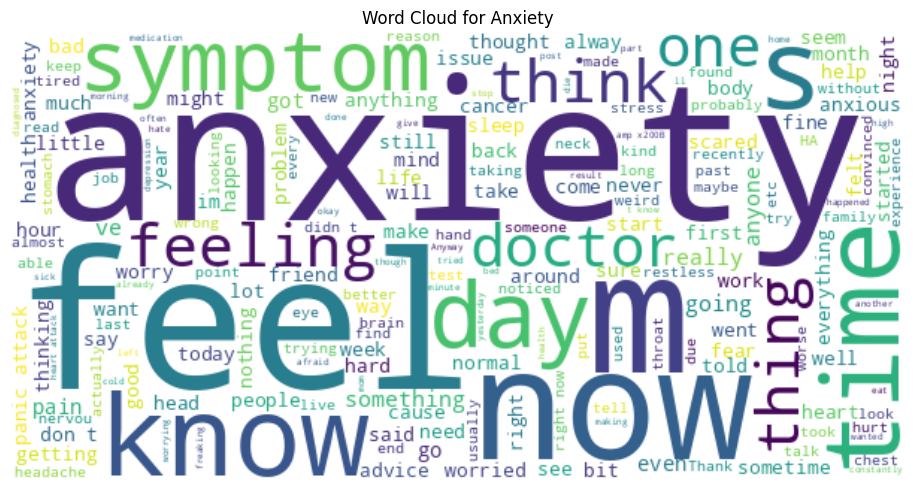

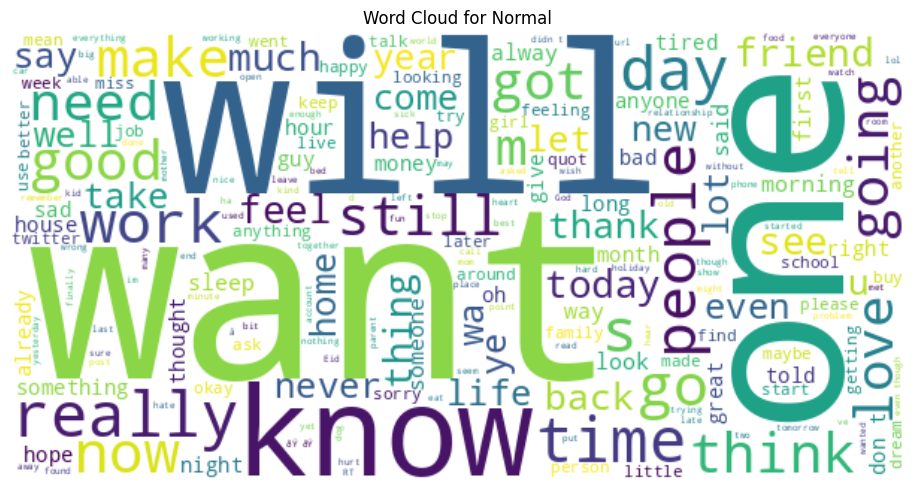

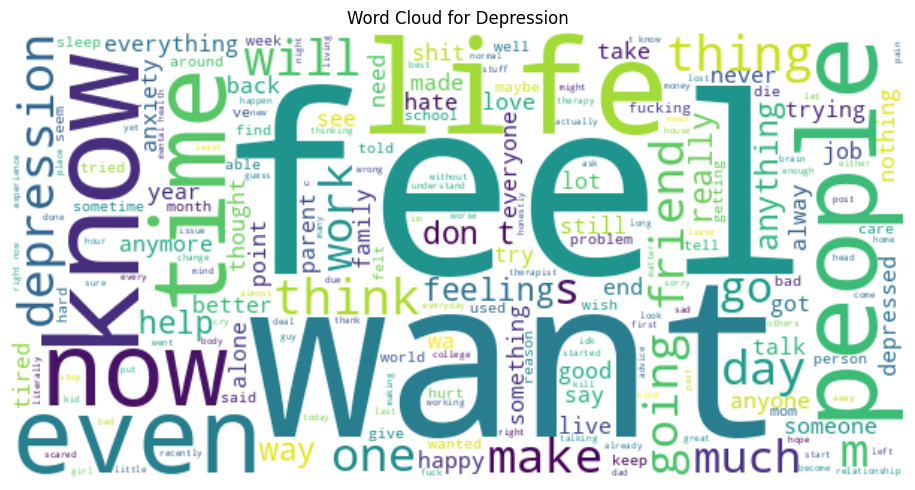

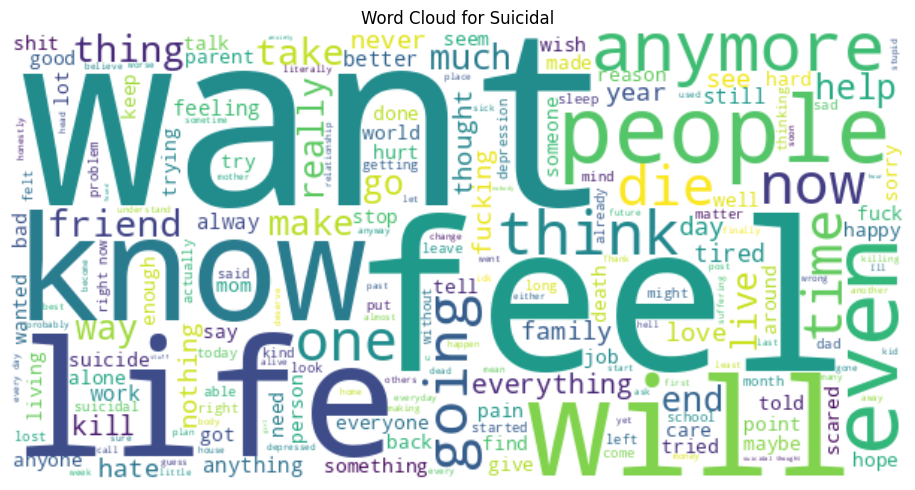

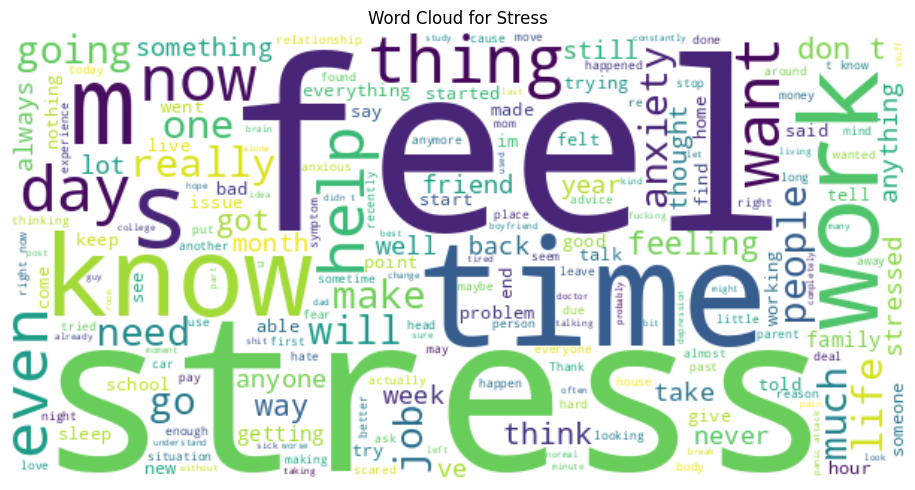

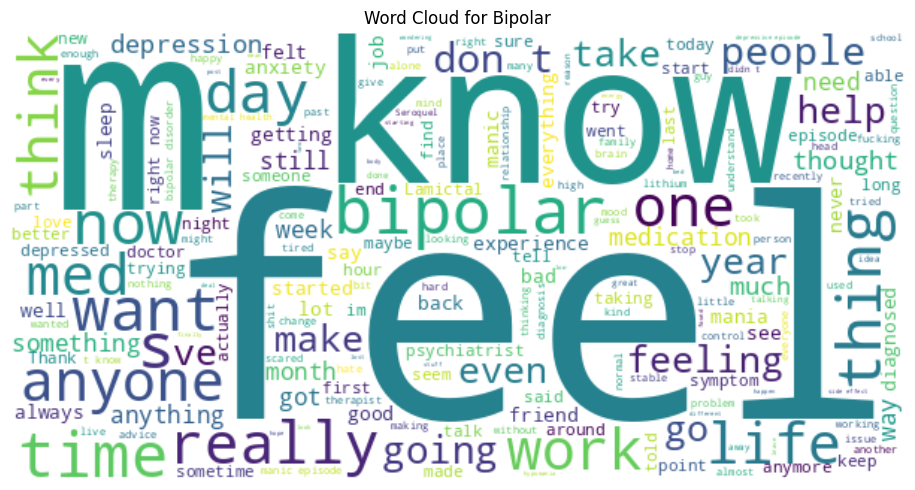

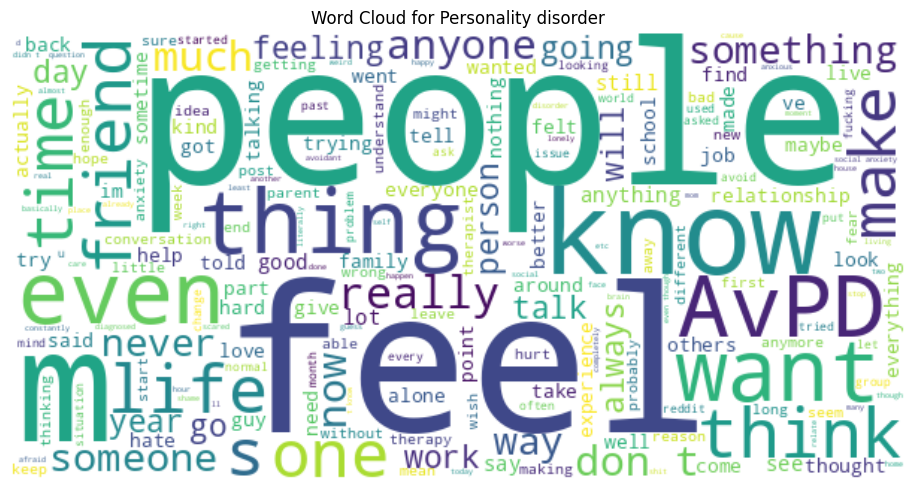

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for label in df['label'].unique():
    text = " ".join(df[df['label'] == label]['text'].astype(str))
    wordcloud = WordCloud(width=600, height=300, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {label.capitalize()}")
    plt.tight_layout()
    plt.show()


In [21]:
# Cleaning & Preprocessing

In [22]:
import spacy
import re

In [23]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

In [24]:
def clean_text(text):
    if pd.isnull(text):
        return ""

    # Lowercase and remove URLs, mentions, hashtags, special characters
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\S+|#\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)

    # Process with spaCy
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return " ".join(tokens)


In [25]:
df['clean_text'] = df['text'].apply(clean_text)

In [26]:
print(df[['text', 'clean_text']].sample(5))

                                                    text  \
50952  Feel like I'm too far gone I'll try to keep th...   
46302  I don't have Bipolar! I have a neurological di...   
37785  it feel we live in such a cruel world people t...   
3564                                    hensemnyaaaa!!!!   
38350                                  no reason in life   

                                              clean_text  
50952  feel like m far go ill try brief tend ramble p...  
46302  not bipolar neurological disorder call kaksisu...  
37785  feel live cruel world people torment want feel...  
3564                                        hensemnyaaaa  
38350                                        reason life  


In [27]:
df_final = df[['clean_text', 'label_id']]

In [28]:
df["clean_text"][1]

'trouble sleep confused mind restless heart tune'

In [29]:
df["text"][1]

'trouble sleeping, confused mind, restless heart. All out of tune'

In [30]:
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
X = df_final['clean_text']
y = df_final['label_id']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
# TF-IDF Vectorizer
# Initialize TfidfVectorizer to convert text data into a matrix of TF-IDF features.
# max_features=10000: Limits the number of features (vocabulary size) to the top 10000 words/ngrams based on term frequency across documents.
# ngram_range=(1, 2): Considers both unigrams (single words) and bigrams (two consecutive words) as features.
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Fit the vectorizer on the training data and transform it.
# fit_transform learns the vocabulary and inverse document frequencies from X_train and then transforms X_train into a TF-IDF matrix.
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the test data using the vocabulary and inverse document frequencies learned from the training data.
# transform only applies the learned transformation to X_test.
X_test_tfidf = tfidf.transform(X_test)

In [34]:
# Reduce dimensionality using Truncated SVD
# Initialize TruncatedSVD to reduce the dimensionality of the TF-IDF features.
# n_components=300: Reduces the number of dimensions to 300, keeping the most important features.
# random_state=42: Ensures reproducibility of the dimensionality reduction.
svd = TruncatedSVD(n_components=300, random_state=42)

# Fit the SVD model on the training TF-IDF data and transform it.
# fit_transform learns the principal components from X_train_tfidf and transforms X_train_tfidf into a lower-dimensional space.
X_train_svd = svd.fit_transform(X_train_tfidf)

# Transform the test TF-IDF data using the SVD model learned from the training data.
# transform applies the learned dimensionality reduction to X_test_tfidf.
X_test_svd = svd.transform(X_test_tfidf)

In [35]:
# Oversample the minority classes using SMOTE
# SMOTE (Synthetic Minority Over-sampling Technique) is used to address class imbalance by generating synthetic samples for minority classes.
# random_state=42: Ensures reproducibility of the oversampling process.
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data (after SVD) and the corresponding labels.
# fit_resample learns the SMOTE parameters from the training data and generates synthetic samples.
X_resampled, y_resampled = smote.fit_resample(X_train_svd, y_train)

In [36]:
# Training baseline model
# Initialize LogisticRegression model
# max_iter=1000: Sets the maximum number of iterations for the solver to converge. Increased for better convergence on potentially complex data.
# class_weight='balanced': Automatically adjusts weights inversely proportional to class frequencies in the input data. This helps to handle class imbalance.
l_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Fit the model to the resampled training data.
# X_resampled: Training data after applying SMOTE and SVD.
# y_resampled: Corresponding labels after applying SMOTE.
l_model.fit(X_resampled, y_resampled)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [37]:
# Predict on the test set
y_pred = l_model.predict(X_test_svd)

# Generate and print the classification report
# The classification report includes precision, recall, f1-score, and support for each class.
# Precision: The ability of the classifier not to label as positive a sample that is negative.
# Recall: The ability of the classifier to find all the positive samples.
# F1-score: A weighted harmonic mean of precision and recall, useful for imbalanced datasets.
# Support: The number of actual occurrences of the class in the specified dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.74       768
           1       0.67      0.78      0.72       556
           2       0.77      0.59      0.67      3081
           3       0.89      0.80      0.84      3269
           4       0.26      0.69      0.38       215
           5       0.39      0.59      0.47       517
           6       0.63      0.72      0.67      2131

    accuracy                           0.71     10537
   macro avg       0.62      0.71      0.64     10537
weighted avg       0.74      0.71      0.72     10537



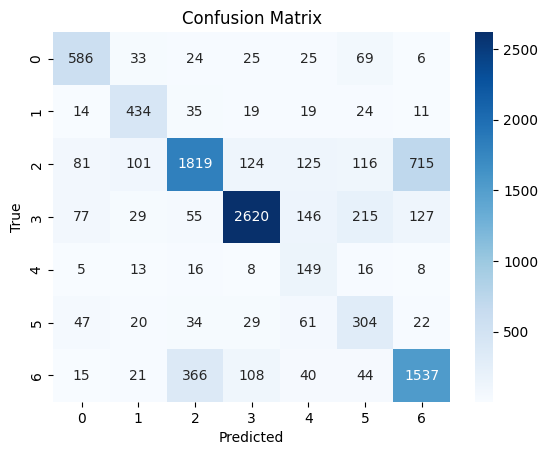

In [38]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [39]:
text = [
    "I feel fine and content with my life lately.",
    "I can't stop worrying even when there's nothing wrong.",
    "Sometimes I think the world would be better without me.",
    "I don’t see the point in anything anymore.",
    "People tell me I act like different persons at different times.",
    "I enjoy my job and feel balanced emotionally.",
    "My mood constantly shifts without any clear reason.",
    "I'm having trouble handling stress at work.",
    "I feel like no one really understands who I am.",
    "I’ve been feeling empty and hopeless lately.",
    "My emotions swing from joy to sadness in minutes.",
    "I can't sleep and my mind won't stop racing.",
    "I often feel overwhelmed and burned out.",
    "Life doesn’t feel worth living these days.",
    "Most days I just feel okay, nothing special.",
]

In [40]:
texts = tfidf.transform(text)
texts = svd.transform(texts)

In [41]:
# Step 2: Predict
preds = l_model.predict(texts)

In [42]:
preds[0], preds[1]

(np.int64(0), np.int64(3))

In [43]:
# Step 3: Map predictions back to label names
id_to_label = {
    0: "anxiety",
    1: "bipolar",
    2: "depression",
    3: "normal",
    4: "personality disorder",
    5: "stress",
    6: "suicidal"
}

# Step 4: Display
for t, pred in zip(text, preds):
    print(f"{t}: {id_to_label[pred]}")

I feel fine and content with my life lately.: anxiety
I can't stop worrying even when there's nothing wrong.: normal
Sometimes I think the world would be better without me.: normal
I don’t see the point in anything anymore.: depression
People tell me I act like different persons at different times.: normal
I enjoy my job and feel balanced emotionally.: stress
My mood constantly shifts without any clear reason.: bipolar
I'm having trouble handling stress at work.: stress
I feel like no one really understands who I am.: bipolar
I’ve been feeling empty and hopeless lately.: stress
My emotions swing from joy to sadness in minutes.: normal
I can't sleep and my mind won't stop racing.: stress
I often feel overwhelmed and burned out.: stress
Life doesn’t feel worth living these days.: depression
Most days I just feel okay, nothing special.: normal


In [44]:
# Transformer Upgrade

In [45]:
df.head()

,text,label,label_id,clean_text
0,oh my gosh,anxiety,0,oh gosh
1,"trouble sleeping, confused mind, restless hear...",anxiety,0,trouble sleep confused mind restless heart tune
2,"All wrong, back off dear, forward doubt. Stay ...",anxiety,0,wrong dear forward doubt stay restless restles...
3,I've shifted my focus to something else but I'...,anxiety,0,ve shift focus m worried
4,"I'm restless and restless, it's been a month n...",anxiety,0,m restless restless month boy mean


In [46]:
# Create a smaller subset of the data for faster experimentation with the Transformer model.
# Sampling 'n' rows randomly from the original dataframe.
# random_state=42: Ensures that the sampling is reproducible.
df_short = df.sample(n=2100, random_state=42)

# Print the shape of the new, smaller dataframe to confirm the number of rows and columns.
df_short.shape

(2100, 4)

In [47]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Split the smaller dataframe into training and validation sets.
# test_size=0.2: Allocates 20% of the data to the validation set and 80% to the training set.
# stratify=df_short['label_id']: Ensures that the proportion of each class is the same in both the training and validation sets, which is important for imbalanced datasets.
# random_state=42: Ensures reproducibility of the split.
df_train, df_val = train_test_split(df_short, test_size=0.2, stratify=df_short['label_id'], random_state=42)

# Convert the pandas DataFrames to Hugging Face Dataset objects.
# This format is required by the Hugging Face Transformers library for training.
# The 'label_id' column is renamed to 'label' to match the expected format for sequence classification models.
train_dataset = Dataset.from_pandas(df_train[['text', 'label_id']].rename(columns={'label_id': 'label'}))
val_dataset = Dataset.from_pandas(df_val[['text', 'label_id']].rename(columns={'label_id': 'label'}))

In [48]:
train_dataset.shape, val_dataset.shape

((1680, 3), (420, 3))

In [49]:
from transformers import AutoTokenizer

# Initialize the tokenizer for the specified model ("distilbert-base-uncased").
# The tokenizer is responsible for converting text into a format that the model can understand (numerical IDs).
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Define a function to tokenize the text in each batch of the dataset.
# batch["text"]: Accesses the text column from the dataset.
# padding="max_length": Pads the tokenized sequences to the maximum length specified.
# truncation=True: Truncates sequences longer than the maximum length.
# max_length=256: Sets the maximum length for the tokenized sequences.
# return_tensors="pt": Returns the tokenized sequences as PyTorch tensors.
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256, return_tensors="pt")

# Apply the tokenize function to the training and validation datasets.
# batched=True: Processes the data in batches for efficiency.
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# Set the format of the datasets to "torch".
# This ensures that the datasets return PyTorch tensors, which are required for training with the Transformers Trainer.
# The specified columns ("input_ids", "attention_mask", "label") are kept.
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

In [50]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Initialize the Transformer model for sequence classification.
# "distilbert-base-uncased": Specifies the pretrained model to use (a smaller, faster version of BERT).
# num_labels=7: Sets the number of output labels for the classification task (corresponding to the 7 mental health statuses).
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=7)

# Define the training arguments for the Trainer.
# output_dir="../outputs/results": Directory where model checkpoints and training outputs will be saved.
# learning_rate=2e-5: The learning rate for the optimizer.
# per_device_train_batch_size=32: Batch size for training on each device (GPU/CPU).
# per_device_eval_batch_size=32: Batch size for evaluation on each device.
# num_train_epochs=2: The total number of training epochs to perform.
# weight_decay=0.01: The weight decay to apply (L2 regularization).
# logging_dir='./logs': Directory for storing training logs.
# eval_strategy="steps": Evaluation is performed at specified step intervals.
# load_best_model_at_end=False: Whether or not to load the best model found during training at the end of training.
# metric_for_best_model="f1": The metric to use to compare different models during evaluation to find the best one.
# fp16=True: Enables mixed precision training (uses 16-bit floating point numbers for faster training).
# logging_steps=500: Number of update steps between two logging events.
# eval_steps=500: Number of update steps between two evaluation calls.
# save_steps=500: Number of update steps between two checkpoint saving calls.
training_args = TrainingArguments(
    output_dir="../outputs/results",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="steps",
    load_best_model_at_end=False,
    metric_for_best_model="f1",
    fp16=True,
    logging_steps=500,
    eval_steps=500,
    save_steps=500,
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    # eval_pred is a tuple with predictions and labels
    logits, labels = eval_pred
    # Get the predicted class with the highest logit score
    preds = np.argmax(logits, axis=-1)
    # Return a dictionary containing the accuracy and macro F1 score
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
    }

In [52]:
train_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 1680
})

In [53]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Assuming y_train is a list/array of class labels for training
train_labels = [int(label) for label in train_dataset['label']]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [54]:
from transformers import Trainer

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # added **kwargs
        # Get the labels from the inputs
        labels = inputs.get("labels")
        # Get the model outputs (logits)
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Define the loss function as CrossEntropyLoss with class weights
        # The class weights are moved to the same device as the model
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        # Calculate the loss using the logits and labels
        loss = loss_fct(logits, labels)

        # Return the loss, and optionally the outputs
        return (loss, outputs) if return_outputs else loss

In [55]:
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor
)

In [56]:
# Train
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: fordstphn (xtiphyn) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


TrainOutput(global_step=53, training_loss=1.8961522804116302, metrics={'train_runtime': 2504.3694, 'train_samples_per_second': 0.671, 'train_steps_per_second': 0.021, 'total_flos': 111282536816640.0, 'train_loss': 1.8961522804116302, 'epoch': 1.0})

In [57]:

# Make predictions on the validation set (or test set if you've defined one)
predictions = trainer.predict(val_dataset)

# Extract predicted labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Evaluation metrics
print("F1 (Macro):", f1_score(labels, preds, average="macro"))
print("Accuracy:", accuracy_score(labels, preds))
confusion_matrix(labels, preds)


F1 (Macro): 0.27691699104879336
Accuracy: 0.4714285714285714


array([[  3,   2,   4,   7,   0,   2,  11],
       [  1,   0,   1,   0,   0,   0,  19],
       [  3,   0,  12,   8,   0,   0, 104],
       [  0,   0,   0, 101,   0,   3,  25],
       [  0,   0,   2,   1,   0,   1,   5],
       [  0,   0,   2,   1,   2,   6,  11],
       [  0,   0,   3,   4,   0,   0,  76]])

In [ ]:
# Save the trained model
trainer.save_model("./saved_model")

# Save the tokenizer (important for inference later)
tokenizer.save_pretrained("./saved_model")


In [59]:
# Classification using XLM-RoBERTa for cross-lingual testing

In [60]:
from transformers import AutoTokenizer

model_name = "./saved_model"  # path where you saved the model

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [61]:
texts = [
    "I feel fine and content with my life lately.",  # normal
    "I can't stop worrying even when there's nothing wrong.",  # anxiety
    "Sometimes I think the world would be better without me.",  # suicidal
    "I don’t see the point in anything anymore.",  # depression
    "People tell me I act like different persons at different times.",  # personality disorder
    "I enjoy my job and feel balanced emotionally.",  # normal
    "My mood constantly shifts without any clear reason.",  # bipolar
    "I'm having trouble handling stress at work.",  # stress
    "I feel like no one really understands who I am.",  # personality disorder
    "I’ve been feeling empty and hopeless lately.",  # depression
    "My emotions swing from joy to sadness in minutes.",  # bipolar
    "I can't sleep and my mind won't stop racing.",  # anxiety
    "I often feel overwhelmed and burned out.",  # stress
    "Life doesn’t feel worth living these days.",  # suicidal
    "Most days I just feel okay, nothing special.",  # normal
]


In [62]:
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [63]:
label_map = {
    0: "anxiety",
    1: "bipolar",
    2: "depression",
    3: "normal",
    4: "personality disorder",
    5: "stress",
    6: "suicidal"
}

In [64]:
import torch.nn.functional as F

inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)

model.eval()
model.to(device) # Move the model to the selected device

with torch.no_grad():
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)  # Convert logits to probabilities
    preds = torch.argmax(probs, dim=1)
    confidences = probs.max(dim=1).values     # Max confidence per sample

# Display predictions, confidence, and full probability distribution
for i, (text, pred, conf) in enumerate(zip(texts, preds, confidences)):
    label = label_map[int(pred)]
    print(f"Text: {text}")
    print(f"→ Prediction: {label} ({conf.item():.2%} confidence)")
    print("→ Probabilities:")
    for idx, prob in enumerate(probs[i]):
        print(f"   {label_map[idx]:<22}: {prob.item():.2%}")
    print()

Text: I feel fine and content with my life lately.
→ Prediction: suicidal (17.05% confidence)
→ Probabilities:
   anxiety               : 12.74%
   bipolar               : 12.51%
   depression            : 15.00%
   normal                : 16.35%
   personality disorder  : 13.55%
   stress                : 12.80%
   suicidal              : 17.05%

Text: I can't stop worrying even when there's nothing wrong.
→ Prediction: suicidal (16.91% confidence)
→ Probabilities:
   anxiety               : 13.35%
   bipolar               : 12.57%
   depression            : 14.93%
   normal                : 16.07%
   personality disorder  : 13.31%
   stress                : 12.85%
   suicidal              : 16.91%

Text: Sometimes I think the world would be better without me.
→ Prediction: normal (17.06% confidence)
→ Probabilities:
   anxiety               : 12.30%
   bipolar               : 12.60%
   depression            : 15.20%
   normal                : 17.06%
   personality disorder  : 13.48%


In [65]:
def classify_texts(texts, model, tokenizer, label_map):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
    return [label_map[int(p)] for p in preds]

results = classify_texts(texts, model, tokenizer, label_map)
print(results)


['suicidal', 'suicidal', 'normal', 'normal', 'suicidal', 'suicidal', 'normal', 'normal', 'suicidal', 'suicidal', 'suicidal', 'suicidal', 'suicidal', 'normal', 'suicidal']


In [66]:
import transformers
print(transformers.__version__)


4.54.1
